<a href="https://colab.research.google.com/github/Cpt-Shaan/gen-models/blob/main/MNIST_Gan_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing a simple GAN (Generative Adversarial Network) to learn the underlying distribution of the MNIST dataset, and generate new samples from the dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
# MNIST dataset
batch_size = 100

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = [0.5], std = [0.5])])

train_data = datasets.MNIST(root = './mnist_data/', train = True, transform = transform, download = True)
test_data = datasets.MNIST(root = './mnist_data/', train = False, transform = transform, download = False)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [15]:
# Class for the Generator

class Generator(nn.Module):
  def __init__(self, noise_dim, output_dim):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(noise_dim, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, 512)
    self.fc4 = nn.Linear(512, 1024)
    self.out = nn.Linear(1024, output_dim)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = F.leaky_relu(self.fc4(x), 0.2)
    x = torch.tanh(self.out(x))
    return x

In [6]:
# Class for the discriminator

class Discriminator(nn.Module):
  def __init__(self, input_dim):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(input_dim, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 128)
    self.out = nn.Linear(128, 1)

  def forward(self, x):
    x = F.dropout(F.leaky_relu(self.fc1(x), 0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.fc2(x), 0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.fc3(x), 0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.fc4(x), 0.2), 0.3)
    x = torch.sigmoid(self.out(x))
    return x

In [16]:
noise_dim = 128
img_dim = 28 * 28

G = Generator(noise_dim, img_dim).to(device)
D = Discriminator(img_dim).to(device)

criterion = nn.BCELoss()

lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [9]:
def train_discriminator(x):

  D.zero_grad()

  x_real, y_real = x.view(-1, 784).to(device), torch.ones(batch_size, 1).to(device)

  D_output_real = D(x_real)
  real_loss = criterion(D_output_real, y_real)

  noise = torch.randn(batch_size, noise_dim).to(device)
  x_fake, y_fake = G(noise), torch.zeros(batch_size, 1).to(device)

  D_output_fake = D(x_fake)
  fake_loss = criterion(D_output_fake, y_fake)

  total_loss = real_loss + fake_loss
  total_loss.backward()
  D_optimizer.step()

  return total_loss.data.item()

In [10]:
def train_generator(x):

  G.zero_grad()

  noise = torch.randn(batch_size, noise_dim).to(device)
  y = torch.ones(batch_size, 1).to(device)

  G_output = G(noise)
  D_output = D(G_output)
  G_loss = criterion(D_output, y)

  G_loss.backward()
  G_optimizer.step()

  return G_loss.data.item()

In [20]:
def train(num_epochs):

  avg_D_losses = []
  avg_G_losses = []

  for epoch in range(1, num_epochs+1):
    D_losses, G_losses = [], []

    for batch_idx, (x, _) in enumerate(train_loader):
      D_losses.append(train_discriminator(x))
      G_losses.append(train_generator(x))

    avg_D_loss = torch.mean(torch.FloatTensor(D_losses))
    avg_G_loss = torch.mean(torch.FloatTensor(G_losses))
    avg_D_losses.append(avg_D_loss)
    avg_G_losses.append(avg_G_loss)
    print(f'Epoch No : [ {epoch} / {num_epochs} ] --> avg_Discriminator_loss : {avg_D_loss}, avg_Generator_loss : {avg_G_loss} ')

  return avg_D_losses, avg_G_losses

In [21]:
avg_D_losses, avg_G_losses = train(200)

Epoch No : [ 1 / 200 ] --> avg_Discriminator_loss : 0.7201464772224426, avg_Generator_loss : 3.2272884845733643 
Epoch No : [ 2 / 200 ] --> avg_Discriminator_loss : 0.45459645986557007, avg_Generator_loss : 3.4621686935424805 
Epoch No : [ 3 / 200 ] --> avg_Discriminator_loss : 0.4488127529621124, avg_Generator_loss : 3.4082260131835938 
Epoch No : [ 4 / 200 ] --> avg_Discriminator_loss : 0.3949286937713623, avg_Generator_loss : 3.4937584400177 
Epoch No : [ 5 / 200 ] --> avg_Discriminator_loss : 0.41145533323287964, avg_Generator_loss : 3.242321252822876 
Epoch No : [ 6 / 200 ] --> avg_Discriminator_loss : 0.40473565459251404, avg_Generator_loss : 3.2367310523986816 
Epoch No : [ 7 / 200 ] --> avg_Discriminator_loss : 0.4782675802707672, avg_Generator_loss : 2.973335027694702 
Epoch No : [ 8 / 200 ] --> avg_Discriminator_loss : 0.466957688331604, avg_Generator_loss : 3.0858113765716553 
Epoch No : [ 9 / 200 ] --> avg_Discriminator_loss : 0.4838652014732361, avg_Generator_loss : 2.9653

In [23]:
torch.save({
            'model_state_dict': D.state_dict(),
            'optimizer_state_dict': D_optimizer.state_dict(),
            }, 'D.pt')

torch.save({
            'model_state_dict': G.state_dict(),
            'optimizer_state_dict': G_optimizer.state_dict(),
            }, 'G.pt')

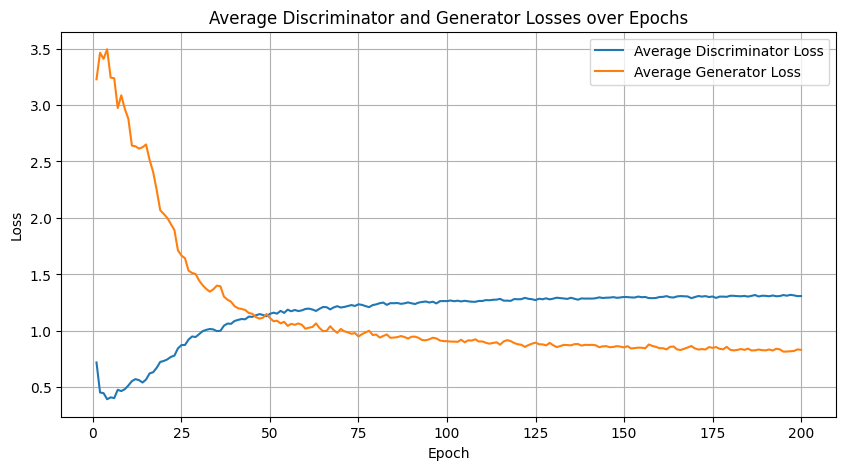

In [26]:
def plot_losses(avg_D_losses, avg_G_losses, num_epochs):

  epochs = range(1, num_epochs + 1)
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, avg_D_losses, label='Average Discriminator Loss')
  plt.plot(epochs, avg_G_losses, label='Average Generator Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Average Discriminator and Generator Losses over Epochs')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_losses(avg_D_losses, avg_G_losses, 200)

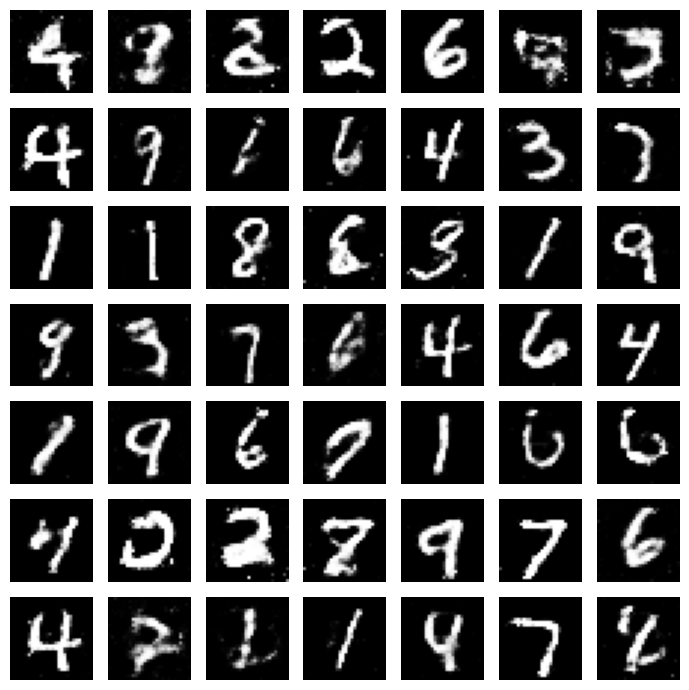

In [28]:
def display_generated_samples(generator_model, noise_dimension, num_samples=49):

  generator_model.eval()
  with torch.no_grad():
      noise = torch.randn(num_samples, noise_dimension).to(device)
      generated_images = generator_model(noise).view(num_samples, 1, 28, 28).cpu()

  fig, axes = plt.subplots(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), figsize=(7, 7))
  for i, ax in enumerate(axes.flat):
      ax.imshow(generated_images[i].squeeze(), cmap='gray')
      ax.axis('off')
  plt.tight_layout()
  plt.show()

display_generated_samples(G, noise_dim, 49)

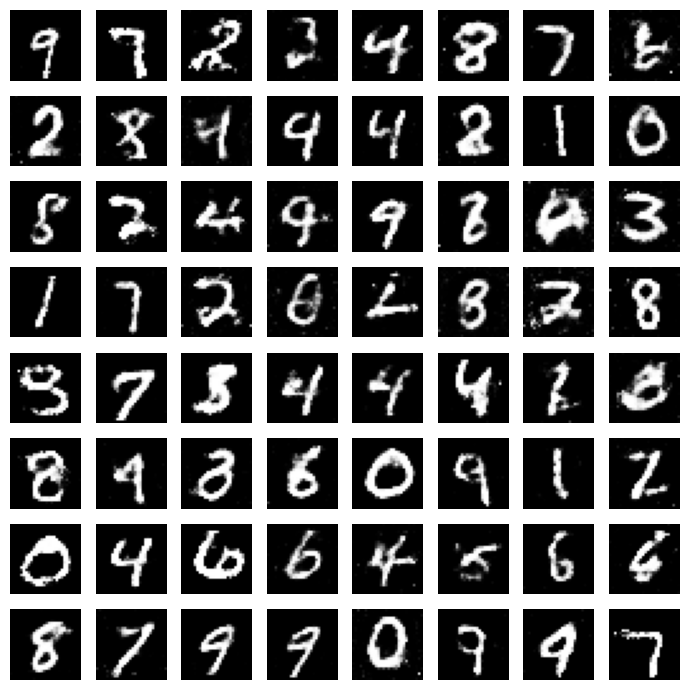

In [29]:
display_generated_samples(G, noise_dim, 64)